In [ ]:
!pip install pyspellchecker

     |████████████████████████████████| 2.5 MB 577 kB/s eta 0:00:01


## Importing Libraries

In [ ]:
import os
import requests
import time

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
nltk.download('omw-1.4')
import spacy

nlp = spacy.load("en_core_web_sm")
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

from spellchecker import SpellChecker
spell = SpellChecker()

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


## Loading dataset

In [ ]:
data_train=pd.read_csv("Train.csv")
data_val = pd.read_csv("Valid.csv")
data_test=pd.read_csv("Test.csv")

In [ ]:
data_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
print(data_train['label'].value_counts())
print(data_test['label'].value_counts())

0    20019
1    19981
Name: label, dtype: int64
1    2505
0    2495
Name: label, dtype: int64


## Preprocessing

### Lower casing, Removing URLs, Removing punctuation, Remong stopwords, and, correcting spelling errors

In [ ]:
i = 0

In [ ]:
import re, string
def process(x):
    
    for punct in string.punctuation:
        x = x.replace(punct, '')
    x = " ".join(x.split())
    
    x = x.lower()
    
    x = word_tokenize(x)
    x = [w for w in x if w not in stopwords]
    x = " ".join(x)
    
    x = x.encode('ascii', 'ignore')
    x = x.decode()
    x = " ".join(x.split())
    
    x  = spell.correction(x)
        
    return x

In [ ]:
data_train['text']=data_train['text'].apply(process)
data_val['text']=data_val['text'].apply(process)
data_test['text']=data_test['text'].apply(process)
data_train.head()

### tokenizing and lemmatizing cleaned data

In [ ]:
i = 0

In [ ]:
def tokenize_lemmatize(x):
    if x == None:
        return " "
    doc = nlp(x)
    x = [token.lemma_ for token in doc]
    x = " ".join(x)
    x = word_tokenize(x)
   
    return x

In [ ]:
data_train['text']=data_train['text'].apply(tokenize_lemmatize)
data_val['text']=data_val['text'].apply(tokenize_lemmatize)
data_test['text']=data_test['text'].apply(tokenize_lemmatize)
data_train.head()

## Visualising most frequent words and bigrams

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(x, n=None):
    final_text = []
    for text in x:
        temp = " ".join(text)
        final_text.append(temp)
    vec = CountVectorizer(stop_words='english').fit(final_text)
    bag_of_words = vec.transform(final_text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda final_text: final_text[1], reverse=True)
    return words_freq[:n]

In [ ]:
common_words = get_top_n_words(data_train['text'], 25)

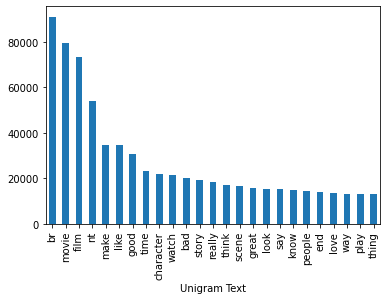

In [ ]:
Unigram = pd.DataFrame(common_words, columns = ['Unigram Text' , 'Count'])
Unigram.groupby('Unigram Text').sum()['Count'].sort_values(ascending=False).plot(kind='bar')
plt.show()

In [ ]:
def get_top_n_bigram(x, n=None):
    final_text = []
    for text in x:
        temp = " ".join(text)
        final_text.append(temp)
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(final_text)
    bag_of_words = vec.transform(final_text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda final_text: final_text[1], reverse=True)
    return words_freq[:n]

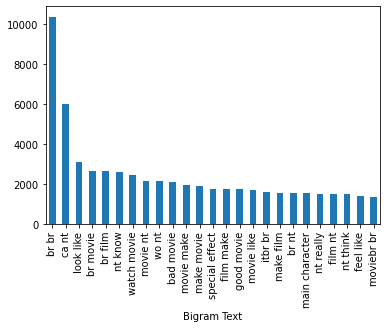

In [ ]:
common_words = get_top_n_bigram(data_train['text'], 25)
Bigram = pd.DataFrame(common_words, columns = ['Bigram Text' , 'Count'])
Bigram.groupby('Bigram Text').sum()['Count'].sort_values(ascending=False).plot(kind='bar')
plt.show()

## Visualising words that represent postive and negative samples by frequency

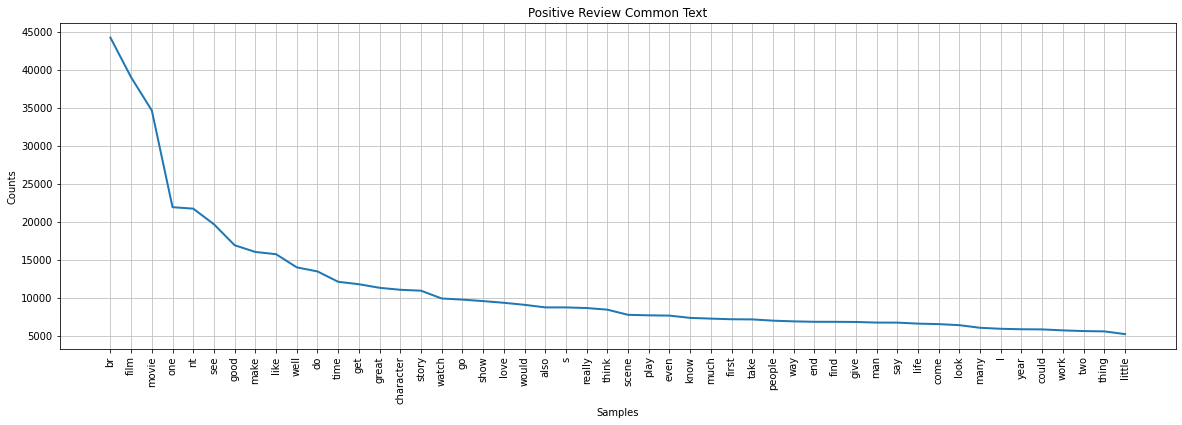

In [ ]:
from nltk.probability import FreqDist
txt = data_train[data_train['label'] == 1].text
final_text = []
for text in txt:
    temp = " ".join(text)
    final_text.append(temp)
pos_freq = FreqDist(' '.join(final_text).split(' '))
plt.figure(figsize=(20,6))
pos_freq.plot(50,cumulative=False,title='Positive Review Common Text')
plt.show()

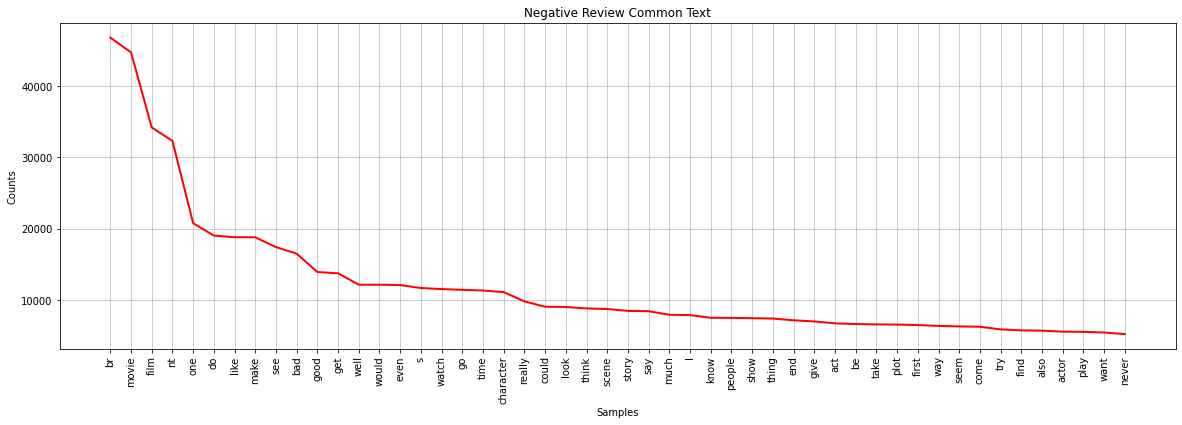

In [ ]:
txt = data_train[data_train['label'] == 0].text
final_text = []
for text in txt:
    temp = " ".join(text)
    final_text.append(temp)
neg_freq = FreqDist(' '.join(final_text).split(' '))
plt.figure(figsize=(20,6))
neg_freq.plot(50,cumulative=False,title='Negative Review Common Text',color='red')
plt.show()

## Splitting and preparing data

In [ ]:
train_x = data_train['text']
valid_x = data_val['text']
test_x = data_test['text']
train_y = data_train['label']
valid_y = data_val['label']
test_y = data_test['label']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Tokenize the sentences
tokenizer = Tokenizer()
#preparing vocabulary
tokenizer.fit_on_texts(train_x)
#converting text into integer sequences
train_x = tokenizer.texts_to_sequences(train_x)
valid_x = tokenizer.texts_to_sequences(valid_x)
test_x = tokenizer.texts_to_sequences(test_x)
#padding to prepare sequences of same length
train_x=pad_sequences(train_x,maxlen=128)
valid_x=pad_sequences(valid_x,maxlen=128)
test_x=pad_sequences(test_x,maxlen=128)

In [ ]:
size_of_vocabulary = len(tokenizer.word_index)+1
print(size_of_vocabulary)

144241


## Defining and running Basic LSTM Model

In [ ]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

model_lstm = Sequential()

model_lstm.add(Embedding(size_of_vocabulary,128,input_length=128, name = "Embedding"))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_1")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_2")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_3")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_4")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_5")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_6")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_7")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_8")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_9")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_10")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_11")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_12")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_13")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, return_sequences=True, name = "LSTM_14")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units = 64, name = "LSTM_15")) 
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(units=2))

model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 128, 128)          18462848  
_________________________________________________________________
LSTM_1 (LSTM)                (None, 128, 64)           49408     
_________________________________________________________________
dropout_60 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 128, 64)           33024     
_________________________________________________________________
dropout_61 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
LSTM_3 (LSTM)                (None, 128, 64)           33024     
_________________________________________________________________
dropout_62 (Dropout)         (None, 128, 64)          

In [ ]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model_lstm.fit(train_x,train_y,batch_size=128,epochs=10,
                    validation_data=(valid_x,valid_y),verbose=1)

2022-09-25 10:20:31.683759: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-09-25 10:20:48.515555: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 61s 134ms/step - loss: 0.7276 - accuracy: 0.4998 - val_loss: 0.7692 - val_accuracy: 0.4972
Epoch 2/10
313/313 [==============================] - 41s 130ms/step - loss: 0.6636 - accuracy: 0.4432 - val_loss: 0.5293 - val_accuracy: 0.2754
Epoch 3/10
313/313 [==============================] - 41s 131ms/step - loss: 0.4393 - accuracy: 0.3589 - val_loss: 0.5227 - val_accuracy: 0.2498
Epoch 4/10
313/313 [==============================] - 41s 131ms/step - loss: 0.4569 - accuracy: 0.3800 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 5/10
313/313 [==============================] - 42s 135ms/step - loss: 0.7029 - accuracy: 0.5013 - val_loss: 0.6922 - val_accuracy: 0.5028
Epoch 6/10
313/313 [==============================] - 42s 134ms/step - loss: 0.7032 - accuracy: 0.5011 - val_loss: 0.6992 - val_accuracy: 0.5028
Epoch 7/10
313/313 [==============================] - 39s 124ms/step - loss: 0.6996 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.5

In [ ]:
loss,acc = model_lstm.evaluate(test_x,test_y)
print('Test Accuracy: {}%'.format(acc*100))

1/1 [==============================] - 0s 60ms/step - loss: 0.7000 - accuracy: 0.3000
Test Accuracy: 30.000001192092896%


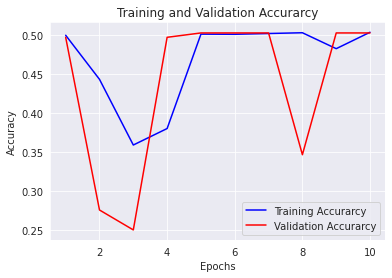

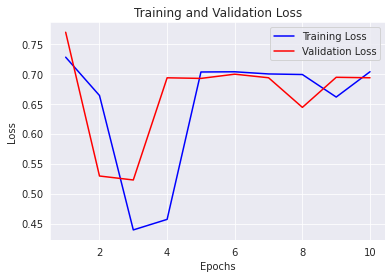

In [ ]:
import seaborn as sns

#Plotting The Graphs for Accuracy and Loss of Model1
sns.set_style("darkgrid")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Defining and Running Bidirectional RNN Model

In [ ]:
from keras.layers import Embedding, RNN, Bidirectional, Dense, Dropout

model_rnn = Sequential()

model_rnn.add(Embedding(size_of_vocabulary,128,input_length=128, name = "Embedding"))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_1"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_2"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_3"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_4"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_5"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_6"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_7"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_8"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_9"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_10"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_11"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_12"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_13"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, return_sequences=True, name = "RNN_14"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Bidirectional(LSTM(units = 64, name = "RNN_15"))) 
model_rnn.add(Dropout(0.2))

model_rnn.add(Dense(units=2))

model_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 128, 128)          18462848  
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 128)          98816     
_________________________________________________________________
dropout_75 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
dropout_76 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
dropout_77 (Dropout)         (None, 128, 128)         

In [ ]:
model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model_rnn.fit(train_x,train_y,batch_size=128,epochs=10,
                    validation_data=(valid_x,valid_y),verbose=1)

Epoch 1/10
313/313 [==============================] - 144s 349ms/step - loss: 1.9936 - accuracy: 0.5071 - val_loss: 1.5207 - val_accuracy: 0.4924
Epoch 2/10
313/313 [==============================] - 103s 328ms/step - loss: 0.7941 - accuracy: 0.5038 - val_loss: 0.5985 - val_accuracy: 0.5028
Epoch 3/10
313/313 [==============================] - 102s 325ms/step - loss: 0.5172 - accuracy: 0.5039 - val_loss: 0.4913 - val_accuracy: 0.7306
Epoch 4/10
313/313 [==============================] - 103s 328ms/step - loss: 0.4605 - accuracy: 0.4924 - val_loss: 0.4391 - val_accuracy: 0.5028
Epoch 5/10
313/313 [==============================] - 103s 329ms/step - loss: 0.5103 - accuracy: 0.5180 - val_loss: 0.4242 - val_accuracy: 0.1906
Epoch 6/10
313/313 [==============================] - 102s 327ms/step - loss: 0.4809 - accuracy: 0.5275 - val_loss: 0.5481 - val_accuracy: 0.4972
Epoch 7/10
313/313 [==============================] - 102s 325ms/step - loss: 0.5551 - accuracy: 0.5496 - val_loss: 0.6210 -

In [ ]:
loss,acc = model_rnn.evaluate(test_x,test_y)
print('Test Accuracy: {}%'.format(acc*100))

157/157 [==============================] - 14s 88ms/step - loss: 0.6702 - accuracy: 0.4462
Test Accuracy: 44.62000131607056%


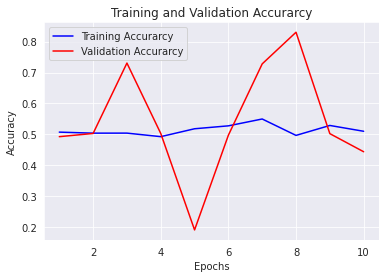

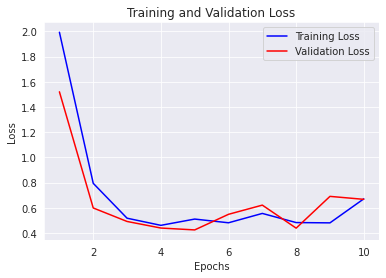

In [ ]:
#Plotting The Graphs for Accuracy and Loss of Model1
sns.set_style("darkgrid")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training Accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation Accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

 We find that test accuracy on the base lstm model is 50.1% (~approx) and for the RNN model is 44.62%
